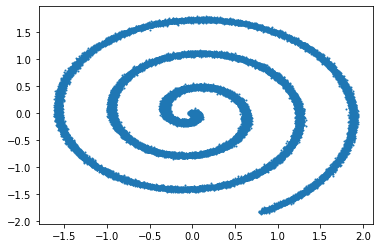

In [19]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_data):

        self.n_data = n_data
        radius = 0.0
        theta = 0.0
        d_theta = -0.005
        d_radius = 0.0005
        self.data = np.random.randn(self.n_data, 2) * 0.02
        n_iter = self.n_data//4000
        idx = 0
        for i in range(4000):
            pos_x = radius * np.cos(theta)
            pos_y = radius * np.sin(theta)
            for j in range(n_iter):
                self.data[idx][0] += pos_x
                self.data[idx][1] += pos_y
                idx += 1
            radius += d_radius
            theta += d_theta
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]



data_size = 80000
dataset = CustomDataSet(n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [0]:
class NormalDensityNetwork(torch.nn.Module):

    def __init__(self, n_in, n_out):
        super(NormalDensityNetwork, self).__init__()
        self.mean = torch.nn.Linear(in_features=n_in, out_features=n_out, bias=True)
        self.log_var = torch.nn.Linear(in_features=n_in, out_features=n_out, bias=True)

    def forward(self, x):
        return self.mean(x), torch.exp(0.5 * self.log_var(x))



def forwardKL_by(eps, sampler_mu, sampler_sig, mu, sig): #KL(N(tar_mu, tar_sig) || N(self.mu, self.sig))
    forward_kl = torch.log(sig) - torch.log(sampler_sig) + 0.5 * (((sampler_sig * eps + sampler_mu - mu)/(sig))**2 -  eps* eps)
    return torch.sum(forward_kl, dim=1).mean()


def forwardKL(tar_mu, tar_sig, mu, sig): #KL(N(tar_mu, tar_sig) || N(self.mu, self.sig))
    forward_kl = torch.log(sig) - torch.log(tar_sig) + ((tar_sig * tar_sig + (tar_mu - mu) * (tar_mu - mu)) / (2.0 * sig * sig)) - 0.5
    return torch.sum(forward_kl, dim=1).mean()


def reverseKL_STD(mu, sig): #KL(N(self.mu, self.sig) || N(0, I))
    reverse_kl = -torch.log(sig) + (sig * sig + mu * mu) / 2.0 - 0.5
    return torch.sum(reverse_kl, dim=1).mean()

def reverseKL_STD_by(eps, mu, sig): #KL(N(self.mu, self.sig) || N(0, I))
    reverse_kl = -torch.log(sig) + 0.5 * ((sig * eps + mu)**2.0 - eps * eps )
    return torch.sum(reverse_kl, dim=1).mean()


def reverseKL(mu, sig, tar_mu, tar_sig): #KL(N(self.mu, self.sig) || N(tar_mu, tar_sig))
    reverse_kl = torch.log(tar_sig) - torch.log(sig) + ((sig * sig + (mu - tar_mu) * (mu - tar_mu)) / (2.0 * tar_sig * tar_sig)) - 0.5
    return torch.sum(reverse_kl, dim=1).mean()


def log_likelihood(x, mu, sig):
    return -torch.sum(torch.log(sig) + 0.5 * (np.log(2.0 * np.pi) + ((mu - x)/sig)**2), dim=1).mean()


def randnLike(tensor):
    return torch.randn_like(tensor)


def stop_grad(x):
    return torch.from_numpy(x.data.numpy())

In [0]:
X_dim = 2
C_dim = 2
Z_dim = 2
mb_size = 64
Qc = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=C_dim))


Qz = torch.nn.Sequential(
    torch.nn.Linear(C_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=Z_dim))


Pc = torch.nn.Sequential(
    torch.nn.Linear(Z_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=C_dim))


Px = torch.nn.Sequential(
    torch.nn.Linear(C_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=X_dim))

Qc_solver = optim.Adam(Qc.parameters(), lr=1e-3)
Qz_solver = optim.Adam(Qz.parameters(), lr=1e-3)
Pc_solver = optim.Adam(Pc.parameters(), lr=1e-3)
Px_solver = optim.Adam(Px.parameters(), lr=1e-3)

In [0]:
ELBO = []
NLL = []
loader = DataLoader(dataset, batch_size=mb_size, shuffle=True, drop_last=True)

In [77]:
num_epochs = 100
for epoch in range(num_epochs):
    ELBO_CUM = 0.0
    NLL_CUM = 0.0
    KLD_CUM = 0.0
    for _, X in enumerate(loader):
        Qc_solver.zero_grad()
        Qz_solver.zero_grad()
        Pc_solver.zero_grad()
        Px_solver.zero_grad()
        
        qcx_mu, qcx_sig = Qc(X)
        qcx_eps = randnLike(qcx_sig)
        qcx = qcx_mu + qcx_eps * qcx_sig

        qzc_mu, qzc_sig = Qz(qcx)
        qzc_eps = randnLike(qzc_sig)

        pcz_mu, pcz_sig = Pc(qzc_mu + qzc_eps * qzc_sig)
        pxc_mu, pxc_sig = Px(qcx)

        prior_kld = reverseKL_STD_by(qzc_eps, qzc_mu, qzc_sig)
        forward_kld = forwardKL_by(qcx_eps, qcx_mu, qcx_sig, pcz_mu, pcz_sig) 
        evidence_ll = log_likelihood(X, pxc_mu, pxc_sig)

        loss = 1.0 * ( 2.0 * prior_kld + forward_kld ) - 1.0 * evidence_ll
        loss.backward()
        KLD_CUM += prior_kld.item()
        Qc_solver.step()
        Qz_solver.step()
        Pc_solver.step()
        Px_solver.step()
        NLL_CUM -= evidence_ll.item()
        # ELBO_CUM  += pxc_ll.item() - prior_kld.item() - forward_kld.item()
    NLL.append(NLL_CUM / len(loader))
    # ELBO.append(ELBO_CUM / len(loader))
    print(NLL[-1])

-3.8783063646316527
-3.876022911453247
-3.88044614109993
-3.913600259017944
-3.8936487358570098
-3.8950273961544037
-3.926388515472412
-3.880491508460045
-3.8886034178256987
-3.847025367593765
-3.8956599749565126
-3.8751201196193694
-3.8790679276943205
-3.8531432188272476
-3.8869206292629244
-3.8902383427619935
-3.8540374816656113
-3.88234701795578
-3.8771656643867494
-3.860310909461975
-3.851960899066925
-3.885285095882416
-3.887187881231308
-3.8692587832927705
-3.8884303429603575
-3.8914640961647033
-3.8984769635677337
-3.899262635755539
-3.903045236825943
-3.909420404624939
-3.9068672956943513
-3.910347136116028
-3.893378977108002
-3.9291917085170747
-3.920984459352493
-3.9141474024772642
-3.890663344144821
-3.9144748249053953
-3.8982790298461913
-3.8881201632499693
-3.9161953578948974
-3.9201033263206484
-3.907865430688858
-3.9201953065633774
-3.889995300579071
-3.898054997062683
-3.905973274707794
-3.9130250765800474
-3.9227023080825805
-3.910685674715042
-3.8928034447193145
-3.90

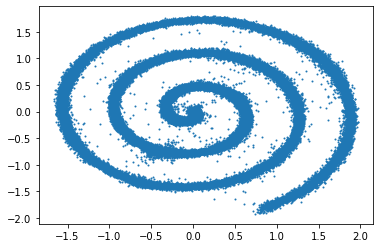

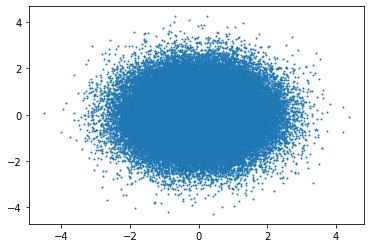

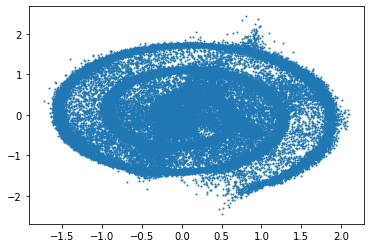

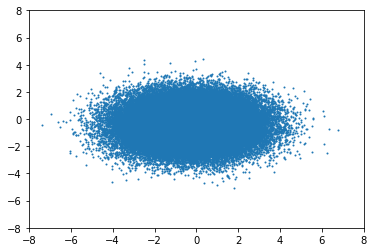

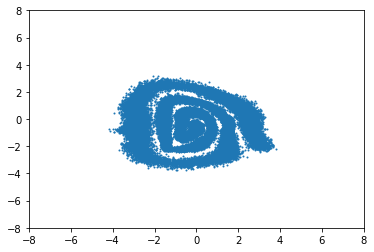

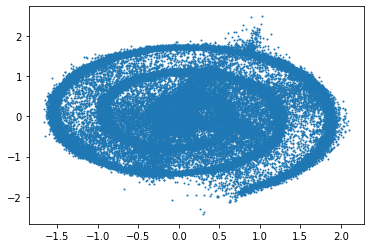

In [78]:
qcx_mu, qcx_sig = Qc(dataset.data)
qcx_eps = randnLike(qcx_sig)
qcx = qcx_mu + qcx_eps * qcx_sig
qzc_mu, qzc_sig = Qz(qcx)
qzc = qzc_mu + qzc_sig * randnLike(qzc_sig)
pcz_mu, pcz_sig = Pc(qzc)
pcz = pcz_mu + pcz_sig * randnLike(pcz_sig)
pxc_mu, pxc_sig = Px(qcx)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)
pxc = pxc.data.numpy()
plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()

qzc = qzc.data.numpy()
plt.scatter(qzc[:,0], qzc[:,1], s=1)
plt.show()

pxc_mu, pxc_sig = Px(pcz)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)
pxc = pxc.data.numpy()

plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()

pcz = pcz.data.numpy()
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.scatter(pcz[:,0], pcz[:,1], s=1)
plt.show()


plt.xlim(-8, 8)
plt.ylim(-8, 8)
qcx = qcx.data.numpy()
plt.scatter(qcx[:,0], qcx[:,1], s=1)
plt.show()

pcz_mu, pcz_sig = Pc(randnLike(qzc_sig))
pcz = pcz_mu + pcz_sig * randnLike(pcz_sig)
pxc_mu, pxc_sig = Px(pcz)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)

pxc = pxc.data.numpy()

plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()


In [0]:
D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1, bias=True),
    torch.nn.Sigmoid())
D_solver = optim.Adam(D.parameters(), lr=1e-3)

ones_label = torch.ones(mb_size, 1)
zeros_label = torch.zeros(mb_size, 1)

In [88]:
num_epochs = 200
for epoch in range(num_epochs):
    ELBO_CUM = 0.0
    NLL_CUM = 0.0
    KLD_CUM = 0.0
    for _, X in enumerate(loader):

        D_solver.zero_grad()
        D_real = D(X)

        pcz_mu, pcz_sig = Pc(torch.randn(mb_size, Z_dim))
        pxc_mu, pxc_sig = Px(pcz_mu + randnLike(pcz_sig) * pcz_sig)
    
        D_fake = D(pxc_mu + pxc_sig * randnLike(pxc_sig))
        D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
        (D_loss_real + D_loss_fake).backward()
        D_solver.step()



        Qc_solver.zero_grad()
        Qz_solver.zero_grad()
        Pc_solver.zero_grad()
        Px_solver.zero_grad()
        
        qcx_mu, qcx_sig = Qc(X) 
        qcx_eps = randnLike(qcx_sig)
        qcx = qcx_mu + qcx_eps * qcx_sig

        qzc_mu, qzc_sig = Qz(qcx)
        qzc_eps = randnLike(qzc_sig)

        pcz_mu, pcz_sig = Pc(qzc_mu + qzc_eps * qzc_sig)
        pxc_mu, pxc_sig = Px(qcx)

        prior_kld = reverseKL_STD_by(qzc_eps, qzc_mu, qzc_sig)
        forward_kld = forwardKL_by(qcx_eps, qcx_mu, qcx_sig, pcz_mu, pcz_sig) 
        evidence_ll = log_likelihood(X, pxc_mu, pxc_sig)

        pcz_mu, pcz_sig = Pc(torch.randn(mb_size, Z_dim))
        pxc_mu, pxc_sig = Px(pcz_mu + randnLike(pcz_sig) * pcz_sig)
        D_loss = nn.binary_cross_entropy(D(pxc_mu + pxc_sig * randnLike(pxc_sig)), ones_label)

        loss = 1.0 * (5.0 * prior_kld + 1.1 * forward_kld ) - 1.0 * evidence_ll + D_loss
        # loss = 1.0 * (3.0 * prior_kld + forward_kld ) - 1.0 * evidence_ll  
        loss.backward()

        KLD_CUM += prior_kld.item()
        Qc_solver.step()
        Qz_solver.step()
        Pc_solver.step()
        Px_solver.step()
        NLL_CUM -= evidence_ll.item()
        # ELBO_CUM  += pxc_ll.item() - prior_kld.item() - forward_kld.item()
    NLL.append(NLL_CUM / len(loader))
    # ELBO.append(ELBO_CUM / len(loader))
    print(NLL[-1], KLD_CUM/len(loader))

-4.04959749109745 0.0004288968027336523
-4.0691976520776745 0.0001593599083367735
-4.060064026594162 0.00017512725422275251
-4.105187519454956 0.0002869969550753012
-4.051637334895134 0.0003747756358992774
-4.052233299446106 0.0004137894324841909
-4.067494070148468 0.00035167391515569763
-4.014048978281021 0.0003004982763028238
-4.044435885715485 0.00039425404763314875
-4.021796092414856 0.0005074926723027601
-4.054877797937393 0.0003012562305200845
-4.086624368715286 0.00027940509191248564
-4.077011812496186 0.00043784718313836493
-4.004329146051407 0.00029424086096696556
-4.0385092222929 0.00021561349441180937
-4.0154385897159575 0.0002042687694192864
-3.9752046295404435 0.0002757900436699856
-4.06723450934887 0.0002632477512175683
-4.0426496948242185 0.0004642266214475967
-4.080054296875 0.000620800679572858
-4.019126887583733 0.00028693535104393957
-4.0750879237651825 0.0003277624893002212
-4.01928278927803 0.0003461316427041311
-4.09893763833046 0.000336729731305968
-4.04659646222

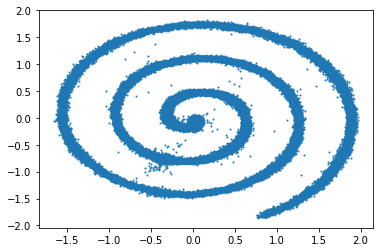

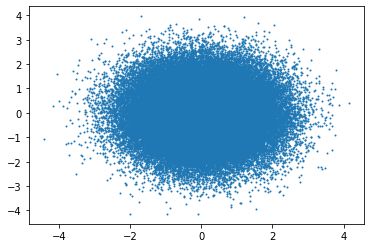

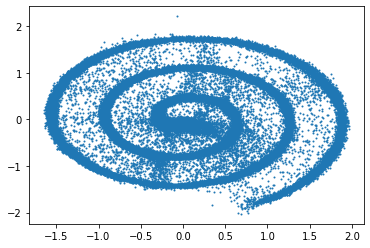

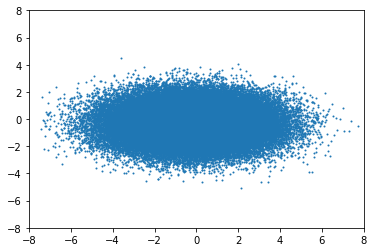

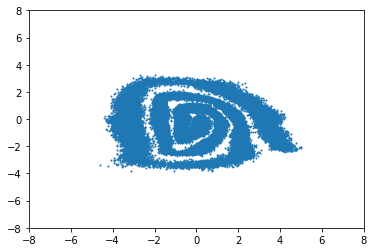

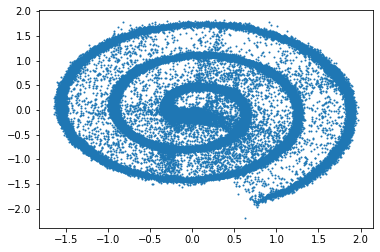

In [89]:
qcx_mu, qcx_sig = Qc(dataset.data)
qcx_eps = randnLike(qcx_sig)
qcx = qcx_mu + qcx_eps * qcx_sig
qzc_mu, qzc_sig = Qz(qcx)
qzc = qzc_mu + qzc_sig * randnLike(qzc_sig)
pcz_mu, pcz_sig = Pc(qzc)
pcz = pcz_mu + pcz_sig * randnLike(pcz_sig)
pxc_mu, pxc_sig = Px(qcx)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)
pxc = pxc.data.numpy()
plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()

qzc = qzc.data.numpy()
plt.scatter(qzc[:,0], qzc[:,1], s=1)
plt.show()

pxc_mu, pxc_sig = Px(pcz)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)
pxc = pxc.data.numpy()

plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()

pcz = pcz.data.numpy()
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.scatter(pcz[:,0], pcz[:,1], s=1)
plt.show()


plt.xlim(-8, 8)
plt.ylim(-8, 8)
qcx = qcx.data.numpy()
plt.scatter(qcx[:,0], qcx[:,1], s=1)
plt.show()

pcz_mu, pcz_sig = Pc(randnLike(qzc_sig))
pcz = pcz_mu + pcz_sig * randnLike(pcz_sig)
pxc_mu, pxc_sig = Px(pcz)
pxc = pxc_mu + pxc_sig * randnLike(pxc_sig)

pxc = pxc.data.numpy()

plt.scatter(pxc[:,0], pxc[:,1], s=1)
plt.show()
